In [1]:
import pandas as pd


In [2]:
df = pd.read_csv('/content/tweetdfsiliconvb275t.csv', encoding='ISO-8859-1')


/tmp/ipython-input-2-794593702.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/tweetdfsiliconvb275t.csv', encoding='ISO-8859-1')


In [3]:
!pip install chardet

import chardet

# Detect file encoding
with open('/content/tweetdfsiliconvb275t.csv', 'rb') as f:
    result = chardet.detect(f.read())

print(result)


{'encoding': 'MacRoman', 'confidence': 0.5720190222197444, 'language': ''}


In [4]:
df = pd.read_csv('/content/tweetdfsiliconvb275t.csv', encoding=result['encoding'])


/tmp/ipython-input-4-522195616.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/tweetdfsiliconvb275t.csv', encoding=result['encoding'])


In [5]:
# Check the shape
print(f"Dataset Shape: {df.shape}")

# View column names and info
df.info()


Dataset Shape: (279803, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279803 entries, 0 to 279802
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    279801 non-null  object 
 1   date          279799 non-null  object 
 2   id            279799 non-null  float64
 3   tweet         279799 non-null  object 
 4   username      279779 non-null  object 
 5   likecount     279779 non-null  float64
 6   retweetcount  279779 non-null  float64
dtypes: float64(3), object(4)
memory usage: 14.9+ MB


In [6]:
# Drop 'Unnamed: 0' if it exists
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Drop duplicate tweets based on the 'tweet' column
df.drop_duplicates(subset='tweet', inplace=True)

# Check updated shape
print(f"Dataset shape after cleaning: {df.shape}")


Dataset shape after cleaning: (275313, 6)


In [7]:
# Check missing values in each column
print(df.isnull().sum())


date             1
id               1
tweet            1
username        13
likecount       13
retweetcount    13
dtype: int64


In [8]:
df.to_csv('cleaned_svb_tweets.csv', index=False)
files.download('cleaned_svb_tweets.csv')


NameError: name 'files' is not defined

In [9]:
!pip install vaderSentiment

In [10]:
df.columns


Index(['date', 'id', 'tweet', 'username', 'likecount', 'retweetcount'], dtype='object')

In [11]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Function to assign sentiment labels based on VADER score
def classify_sentiment(score):
    if score >= 0.3:
        return 'Positive'
    elif score <= -0.3:
        return 'Negative'
    else:
        return 'Neutral'

# Apply VADER on 'tweet' column directly
df['compound_score'] = df['tweet'].astype(str).apply(lambda x: analyzer.polarity_scores(x)['compound'])
df['sentiment_label'] = df['compound_score'].apply(classify_sentiment)


In [12]:
df['sentiment_label'].value_counts()


,count
sentiment_label,
Neutral,137467
Negative,98450
Positive,39396


In [13]:
df.to_csv('/content/svb_labeled_tweets.csv', index=False)


In [14]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['sentiment_label'], random_state=42)


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['tweet'].astype(str))
X_test = vectorizer.transform(test_df['tweet'].astype(str))


In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(train_df['sentiment_label'])
y_test = le.transform(test_df['sentiment_label'])


In [17]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

Accuracy: 0.8619036376514174
              precision    recall  f1-score   support

    Negative       0.89      0.88      0.89     19690
     Neutral       0.86      0.89      0.88     27494
    Positive       0.80      0.70      0.75      7879

    accuracy                           0.86     55063
   macro avg       0.85      0.83      0.84     55063
weighted avg       0.86      0.86      0.86     55063



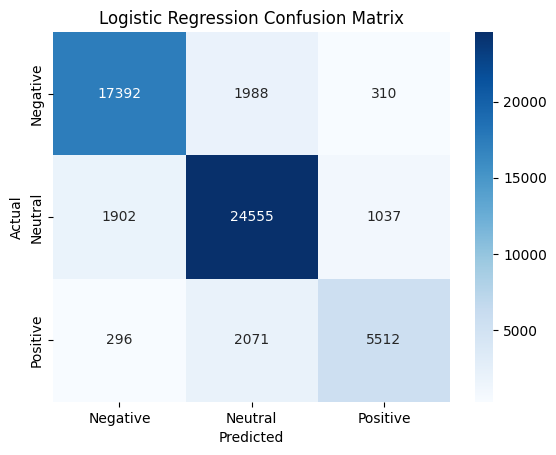

In [22]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

y_pred = lr_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred, target_names=le.classes_))

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()


In [23]:
import joblib

joblib.dump(lr_model, 'logistic_regression_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(le, 'label_encoder.pkl')


['label_encoder.pkl']

In [24]:
!pip install transformers
!pip install datasets


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from tqdm import tqdm


In [19]:
# Load your labeled dataset
df = pd.read_csv('/content/svb_labeled_tweets.csv')

# Drop NaNs for safety
df = df.dropna(subset=['tweet', 'sentiment_label'])

# Label Encode sentiment labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment_label'])  # 0=Negative, 1=Neutral, 2=Positive

# Save encoder for later
import joblib
joblib.dump(le, 'bert_label_encoder.pkl')

# Train-Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['tweet'].astype(str).tolist(),
    df['label'].tolist(),
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)


In [20]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=64)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [21]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)


In [22]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
small_train_dataset = torch.utils.data.Subset(train_dataset, range(0, 1000))
small_val_dataset = torch.utils.data.Subset(val_dataset, range(0, 300))

train_loader = DataLoader(small_train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(small_val_dataset, batch_size=16)


In [24]:
num_epochs = 1


In [25]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=64)


In [29]:
num_epochs = 100

small_train_dataset = torch.utils.data.Subset(train_dataset, range(0, 1000))
small_val_dataset = torch.utils.data.Subset(val_dataset, range(0, 300))

train_loader = DataLoader(small_train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(small_val_dataset, batch_size=16)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * num_epochs
)

for epoch in range(num_epochs):
    model.train()
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

Epoch 99: 100%|██████████| 63/63 [00:12<00:00,  5.19it/s, loss=0.000119]


In [30]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(batch['labels'].cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')


Validation Accuracy: 0.7033
Precision: 0.7114
Recall: 0.7033
F1-Score: 0.6967


In [35]:
# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['tweet'].astype(str),
    df['label'],
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 128

# Custom Dataset
class TweetDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=max_len)
        self.labels = list(labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_texts[:5000], train_labels[:5000])
val_dataset   = TweetDataset(val_texts[:2000], val_labels[:2000])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)

# Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * len(train_loader) * num_epochs),
    num_training_steps=len(train_loader) * num_epochs
)

# Training
for epoch in range(num_epochs):
    model.train()
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        loop.set_description(f'Epoch {epoch+1}')
        loop.set_postfix(loss=loss.item())

# Evaluation
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(batch['labels'].cpu().numpy())

# Metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 3: 100%|██████████| 157/157 [01:38<00:00,  1.59it/s, loss=0.381]


Validation Accuracy: 0.8000
Precision: 0.7989
Recall: 0.8000
F1-Score: 0.7974


In [41]:
!pip install gensim scikit-learn


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use cleaned tweet texts
texts = df['tweet'].astype(str).tolist()

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = vectorizer.fit_transform(texts)


In [1]:
!pip install numpy==1.23.5
!pip install --upgrade --force-reinstall gensim


  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached smart_open-7.3.0.post1-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
Using cached smart_open-7.3.0.post1-py3-none-any.whl (61 kB)
Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (

In [28]:
import gensim
from gensim import corpora, models

# Create Dictionary
terms = vectorizer.get_feature_names_out()
corpus = gensim.matutils.Sparse2Corpus(X_tfidf, documents_columns=False)
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())


In [29]:
lda_model = models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=5,
    random_state=42,
    passes=10
)


In [30]:
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic #{idx+1}: {topic}\n")


Topic #1: 0.024*"usdc" + 0.021*"circle" + 0.016*"bank" + 0.015*"https" + 0.015*"silicon" + 0.015*"valley" + 0.014*"share" + 0.013*"üá" + 0.011*"la" + 0.010*"reserves"

Topic #2: 0.024*"el" + 0.020*"la" + 0.020*"en" + 0.013*"que" + 0.013*"bank" + 0.013*"valley" + 0.013*"https" + 0.012*"silicon" + 0.012*"del" + 0.010*"se"

Topic #3: 0.028*"https" + 0.026*"bank" + 0.023*"silicon" + 0.023*"valley" + 0.017*"shut" + 0.016*"regulators" + 0.014*"fdic" + 0.013*"insured" + 0.011*"seized" + 0.010*"deposits"

Topic #4: 0.043*"bank" + 0.041*"silicon" + 0.041*"valley" + 0.026*"https" + 0.012*"halted" + 0.012*"silvergate" + 0.009*"crypto" + 0.008*"collapse" + 0.008*"woes" + 0.007*"shoots"

Topic #5: 0.024*"bank" + 0.019*"valley" + 0.019*"silicon" + 0.015*"https" + 0.008*"failure" + 0.008*"financial" + 0.008*"largest" + 0.007*"regulators" + 0.007*"äôs" + 0.007*"svb"



In [32]:
from gensim import corpora

# Split your texts into tokens (word lists)
tokenized_texts = [tweet.split() for tweet in texts]

# Create a proper Gensim dictionary
dictionary = corpora.Dictionary(tokenized_texts)


In [33]:
coherence_model_lda = CoherenceModel(
    model=lda_model,
    texts=tokenized_texts,
    dictionary=dictionary,
    coherence='c_v'
)

coherence_score = coherence_model_lda.get_coherence()
print(f'\nCoherence Score: {coherence_score:.4f}')



Coherence Score: 0.5830


In [16]:
import joblib

lr_model = joblib.load('logistic_regression_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')
le = joblib.load('label_encoder.pkl')


In [24]:
import torch
from transformers import BertForSequenceClassification


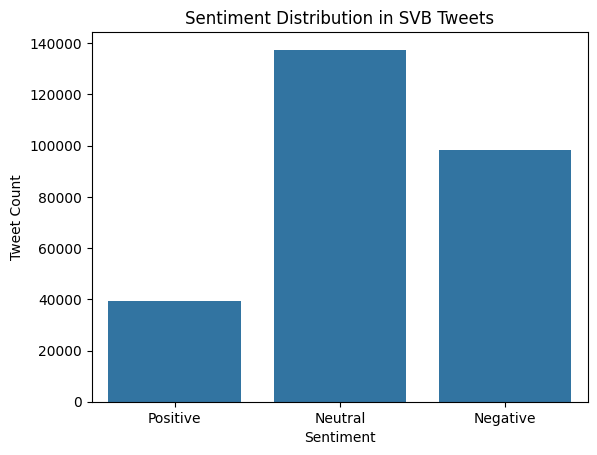

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='sentiment_label', data=df, order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment Distribution in SVB Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Count')
plt.show()


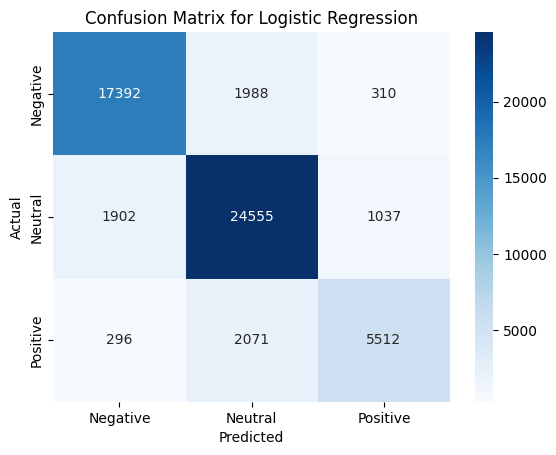

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


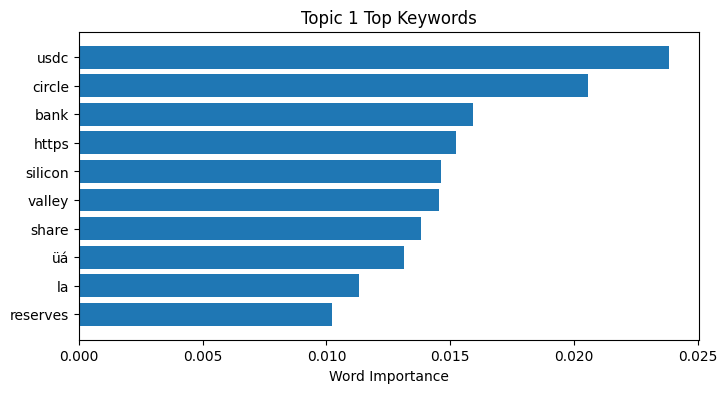

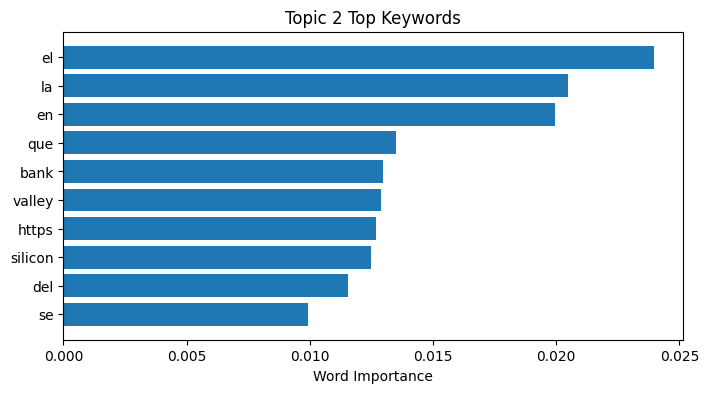

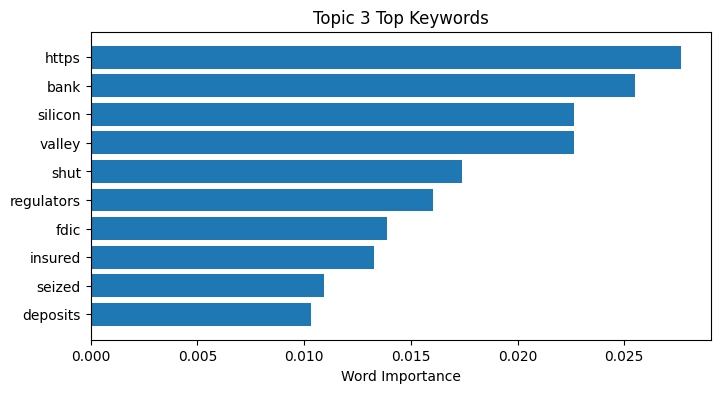

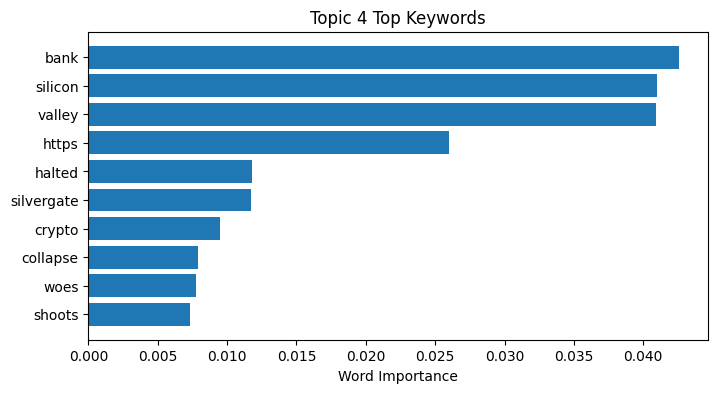

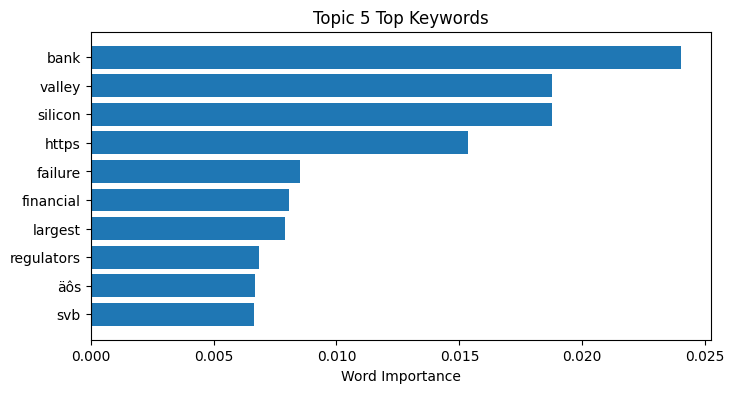

In [37]:
import matplotlib.pyplot as plt

for i, topic in lda_model.show_topics(formatted=False):
    words = [word for word, _ in topic]
    weights = [weight for _, weight in topic]
    plt.figure(figsize=(8, 4))
    plt.barh(words, weights)
    plt.gca().invert_yaxis()
    plt.title(f'Topic {i+1} Top Keywords')
    plt.xlabel('Word Importance')
    plt.show()


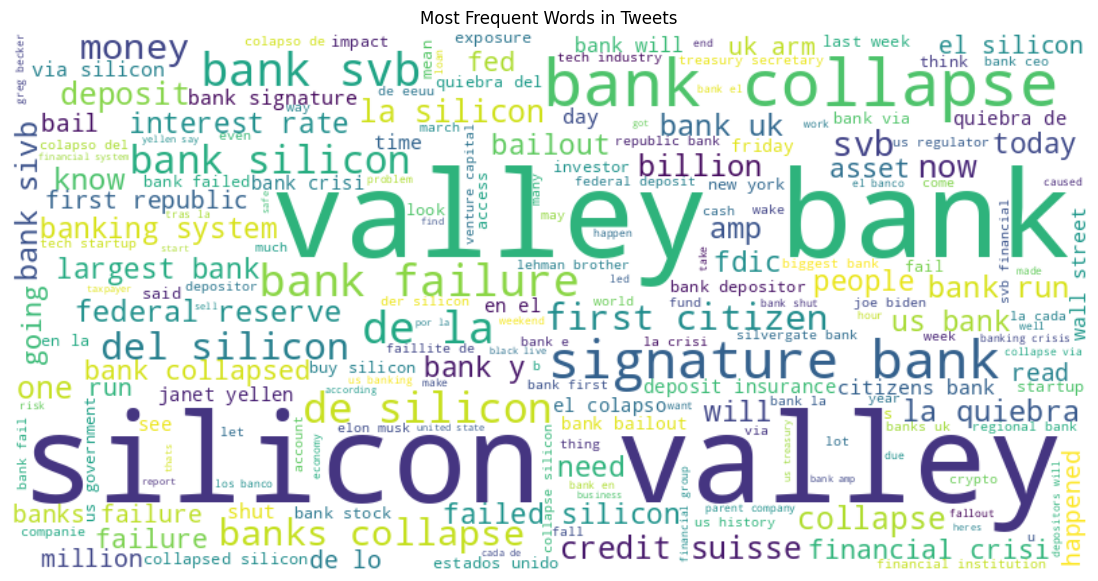

In [ ]:
from wordcloud import WordCloud

text_combined = " ".join(df['clean_text'].dropna().tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Tweets")
plt.show()


In [ ]:

top_positive = df[df['vader_sentiment'] == 'positive'].sort_values(by='likecount', ascending=False).head(10)
print(top_positive[['tweet', 'likecount', 'vader_score']])


top_negative = df[df['vader_sentiment'] == 'negative'].sort_values(by='likecount', ascending=False).head(10)
print(top_negative[['tweet', 'likecount', 'vader_score']])


                                                                       tweet  \
date                                                                           
2023-03-14 20:57:03+00:00  WOW... Silicon Valley Bank gave $73,450,000 to...   
2023-03-12 22:55:09+00:00  You donât actually think our government is g...   
2023-03-11 16:38:54+00:00  If you just lost millions in the Silicon Valle...   
2023-03-15 11:31:00+00:00  BREAKING: California Governor Gavin Newsom lob...   
2023-03-11 15:13:22+00:00  Silicon Valley Bank was the main bank for two ...   
2023-03-14 13:09:52+00:00  Silicon Valley âBankâ really operated like...   
2023-03-16 12:36:26+00:00  1. Fox News' @JesseBWatters told millions of v...   
2023-03-13 16:15:00+00:00  On Friday, the FDIC â the government regulat...   
2023-03-13 21:27:46+00:00  I guess if East Palestine, Ohio had more major...   
2023-03-13 00:48:34+00:00  At my direction, @SecYellen and my National Ec...   

                           likecount  v

In [ ]:
sentiment_counts = df['vader_sentiment'].value_counts(normalize=True) * 100
print(sentiment_counts)


vader_sentiment
negative    46.482296
neutral     32.625921
positive    20.891783
Name: proportion, dtype: float64


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])

print(tfidf_matrix.shape)

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

print(tfidf_df.sum().sort_values(ascending=False).head(10))


(279799, 1000)
bank         30568.779637
valley       26767.597727
silicon      26649.167696
collapse     11307.848859
banks         8472.241870
la            7315.558314
svb           5699.954804
failure       4927.077832
el            4704.277495
signature     4274.694523
dtype: float64


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_features=1000, stop_words='english')

bow_matrix = bow_vectorizer.fit_transform(df['clean_text'])

bow_df = pd.DataFrame(bow_matrix.toarray(), columns=bow_vectorizer.get_feature_names_out())

print(bow_df.sum().sort_values(ascending=False).head(10))


bank        316544
valley      280898
silicon     280111
collapse     49440
banks        39892
la           37160
svb          25288
el           22810
en           19662
failure      17847
dtype: int64


In [ ]:

bigram_vectorizer = CountVectorizer(ngram_range=(2,2), max_features=20, stop_words='english')

bigram_matrix = bigram_vectorizer.fit_transform(df['clean_text'])

bigram_df = pd.DataFrame(bigram_matrix.toarray(), columns=bigram_vectorizer.get_feature_names_out())

print(bigram_df.sum().sort_values(ascending=False).head(10))


silicon valley      278715
valley bank         246659
bank collapse        20859
valley banks         20297
signature bank       13955
collapse silicon     12763
bank svb             10131
bank failure          8411
bank signature        7835
del silicon           7215
dtype: int64


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, random_state=42)

lda.fit(tfidf_matrix)

terms = tfidf_vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    print(f"\nTop words for Topic #{i+1}:")
    print([terms[i] for i in topic.argsort()[-10:]])



Top words for Topic #1:
['por', 'los', 'silicon', 'valley', 'que', 'bank', 'del', 'en', 'el', 'la']

Top words for Topic #2:
['svb', 'fdic', 'yellen', 'bailout', 'hsbc', 'uk', 'collapse', 'silicon', 'valley', 'bank']

Top words for Topic #3:
['signature', 'crisis', 'regulators', 'financial', 'banks', 'failure', 'collapse', 'silicon', 'valley', 'bank']

Top words for Topic #4:
['funds', 'deposits', 'circle', 'cash', 'billion', 'usdc', 'citizens', 'valley', 'silicon', 'bank']

Top words for Topic #5:
['like', 'biden', 'risk', 'failure', 'banking', 'collapse', 'banks', 'valley', 'silicon', 'bank']


In [ ]:
print("LDA Perplexity: ", lda.perplexity(tfidf_matrix))


LDA Perplexity:  672.399626583833


In [ ]:
df = df[['clean_text', 'vader_sentiment']].dropna()

# Encode labels numerically
label_dict = {'positive': 2, 'neutral': 1, 'negative': 0}
df['label'] = df['vader_sentiment'].map(label_dict)

# Check class distribution
print(df['label'].value_counts())


label
0    130057
1     91287
2     58455
Name: count, dtype: int64


In [ ]:
print("LDA Model Perplexity: ", lda.perplexity(X_tfidf))


LDA Model Perplexity:  723.9553693700817


In [ ]:
# Install packages
!pip install transformers torch textblob nltk gensim --quiet

# Imports
import pandas as pd
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from gensim import corpora, models
from nltk.tokenize import word_tokenize
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')


df = pd.read_csv('tweetdfsiliconvb275t.csv')


df_unique = df.drop_duplicates(subset=['tweet']).head(5)

vader = SentimentIntensityAnalyzer()
df_unique['vader_score'] = df_unique['tweet'].apply(lambda x: vader.polarity_scores(str(x))['compound'])

texts = [word_tokenize(str(tweet).lower()) for tweet in df_unique['tweet']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
lda_model = models.LdaModel(corpus, num_topics=2, id2word=dictionary, passes=5)
topics = lda_model.print_topics(num_words=5)
print("\n Topics Found:")
for topic in topics:
    print(topic)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

inputs = tokenizer(df_unique['tweet'].astype(str).tolist(), return_tensors="pt", padding=True, truncation=True, max_length=128)

with torch.no_grad():
    outputs = model(**inputs)
predictions = torch.argmax(outputs.logits, dim=1)
df_unique['bert_pred'] = predictions.tolist()

print("\n Final Hybrid Results:")
print(df_unique[['tweet', 'vader_score', 'bert_pred']])


/tmp/ipython-input-23-4177010075.py:18: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('tweetdfsiliconvb275t.csv', encoding='latin-1')



📊 Topics Found:
(0, '0.042*"." + 0.036*"the" + 0.036*"to" + 0.032*"bank" + 0.025*"valley"')
(1, '0.027*"the" + 0.026*"of" + 0.025*"," + 0.025*"on" + 0.025*"bank"')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Final Hybrid Results:
                                               tweet  vader_score  bert_pred
0  The Biden administration, placing blame on Tru...      -0.4939          1
1  @1Nicdar With a quick call to his Washington d...       0.2263          1
2  From risky investments to lack of regulatory o...      -0.8126          1
3  Boxed bankruptcy could be blamed on Silicon Va...      -0.6858          1
4  Your money isnât safe in banks. They donât...       0.4767          1


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

bert_preds = []


texts = df['clean_tweet'].head(len(true_labels)).tolist()

for text in texts:
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)
    pred = torch.argmax(probs, dim=1).item()
    bert_preds.append(pred)

print("BERT predictions:", bert_preds)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT predictions: [1, 1, 0, 0, 1, 0, 1, 1, 1, 0]


In [ ]:
df[['tweet', 'clean_tweet', 'vader_score', 'bert_pred']].head(10)


,tweet,clean_tweet,vader_score,bert_pred
0,"The Biden administration, placing blame on Tru...",the biden administration placing blame on trum...,-0.4939,1.0
1,@1Nicdar With a quick call to his Washington d...,with a quick call to his washington democrats...,0.2263,1.0
2,From risky investments to lack of regulatory o...,from risky investments to lack of regulatory o...,-0.8126,1.0
3,Boxed bankruptcy could be blamed on Silicon Va...,boxed bankruptcy could be blamed on silicon va...,-0.6858,0.0
4,Your money isnât safe in banks. They donât...,your money isnât safe in banks they donât ...,0.4767,1.0
5,The recent failure of Silicon Valley Bank (SVB...,the recent failure of silicon valley bank svb ...,-0.8481,1.0
6,#LasMÃ¡sLeÃ­das ð£ï¸ | El rescate de Silico...,lasmã¡sleã­das ð£ï¸ el rescate de silicon ...,0.0000,1.0
7,Silicon Valley Lawmaker Explores Legislation A...,silicon valley lawmaker explores legislation a...,-0.4939,1.0
8,Silicon Valley Lawmaker Explores Legislation A...,silicon valley lawmaker explores legislation a...,-0.4939,1.0
9,@JaystaLee @SuperTalismanCD Well Jesusâs sav...,well jesusâs saving account better not hav...,0.6124,0.0


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
df['like_bin'] = pd.cut(df['likecount'], bins=[-1, 0, 5, 50, 1000], labels=['No Likes', 'Low', 'Medium', 'High'])

ct = pd.crosstab(df['like_bin'], df['bert_pred'])
chi2, p, dof, ex = chi2_contingency(ct)

print(ct)
print(f"Chi-Square Stat = {chi2:.3f}, p-value = {p:.4f}")


bert_pred      0      1      2
like_bin                      
No Likes   54072  54044  54269
Low        25128  25481  25105
Medium     10271  10310  10106
High        3272   3308   3280
Chi-Square Stat = 5.481, p-value = 0.4837


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

df['vader_score'] = df['tweet'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])


print(df.head())


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


  Unnamed: 0                       date            id  \
0          0  2023-04-03 23:57:12+00:00  1.643040e+18   
1          1  2023-04-03 23:56:59+00:00  1.643040e+18   
2          2  2023-04-03 23:51:19+00:00  1.643040e+18   
3          3  2023-04-03 23:47:54+00:00  1.643040e+18   
4          4  2023-04-03 23:46:25+00:00  1.643040e+18   

                                               tweet        username  \
0  The Biden administration, placing blame on Tru...  TiffinOhioNews   
1  @1Nicdar With a quick call to his Washington d...      DennisDhg2   
2  From risky investments to lack of regulatory o...   worklife_news   
3  Boxed bankruptcy could be blamed on Silicon Va...  ChambaAnthony1   
4  Your money isnât safe in banks. They donât...      mzarifzeek   

   likecount  retweetcount  like_bin  bert_pred  vader_score  
0        0.0           0.0  No Likes          2      -0.4939  
1        0.0           0.0  No Likes          0       0.2263  
2        3.0           0.0       Lo

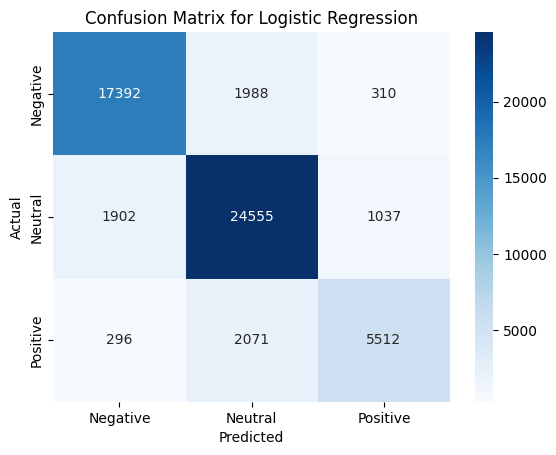

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


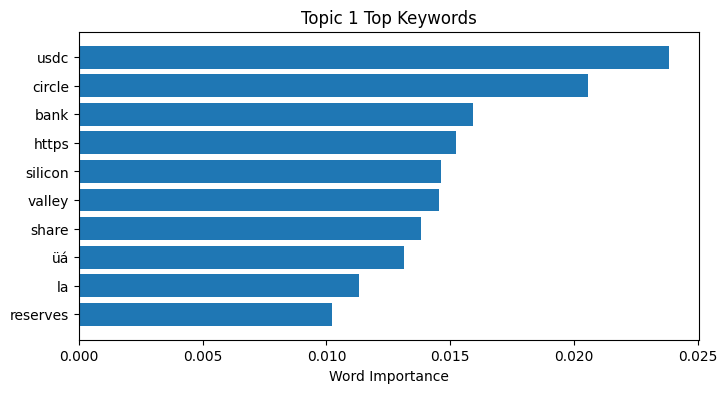

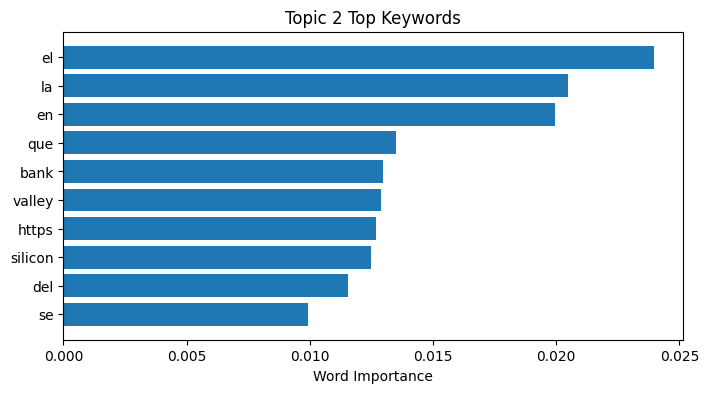

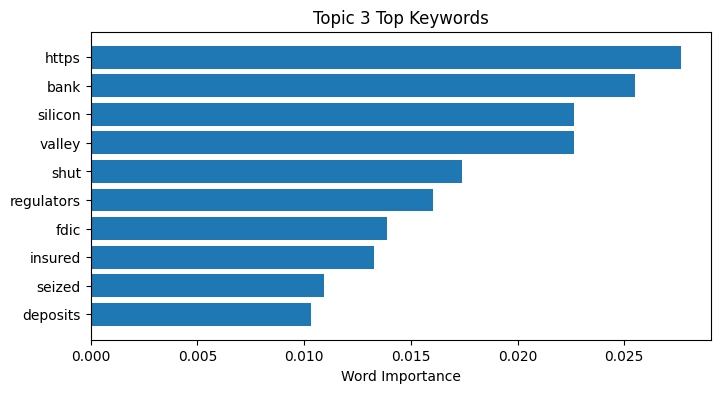

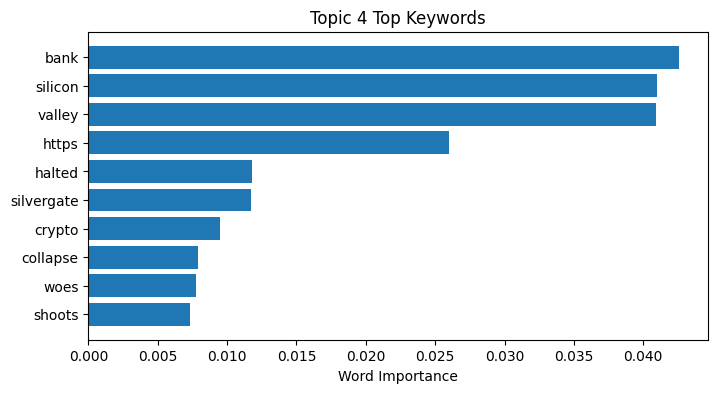

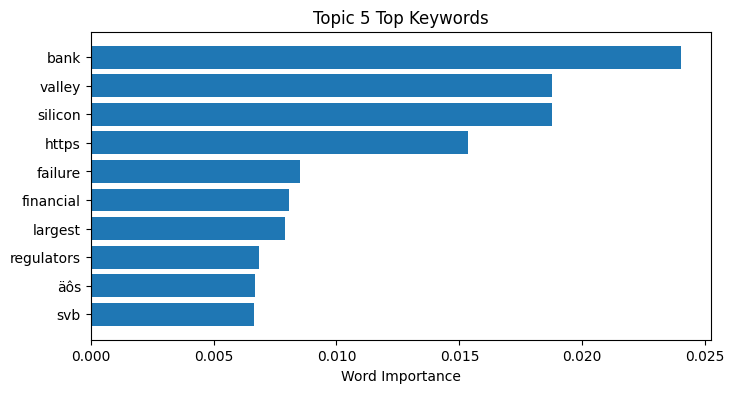

In [37]:
import matplotlib.pyplot as plt

for i, topic in lda_model.show_topics(formatted=False):
    words = [word for word, _ in topic]
    weights = [weight for _, weight in topic]
    plt.figure(figsize=(8, 4))
    plt.barh(words, weights)
    plt.gca().invert_yaxis()
    plt.title(f'Topic {i+1} Top Keywords')
    plt.xlabel('Word Importance')
    plt.show()
